This is our solution for the competition HMS - Harmful Brain Activity Classification on kaggle.\
Our team includes: **Thai Ha Dang, Yue Li, and Vijay Budala**\
The competition Started on Jan 9, 2024 and Closed Apr 8, 2024\
The information of competition can be found here: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification \
date of version: Apr 07, 2024


# Ensemble of three models:
- Model 1: RESNET34
- Model 2: spectrogram+mMobileNet
- Model 3: EfficientNet

**Dataset**

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" 
import keras_cv
import keras
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt 

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [4]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [5]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))
# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


In [6]:
df.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'eeg_path',
       'spec_path', 'spec2_path', 'class_name', 'class_label'],
      dtype='object')

In [7]:
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

<Axes: >

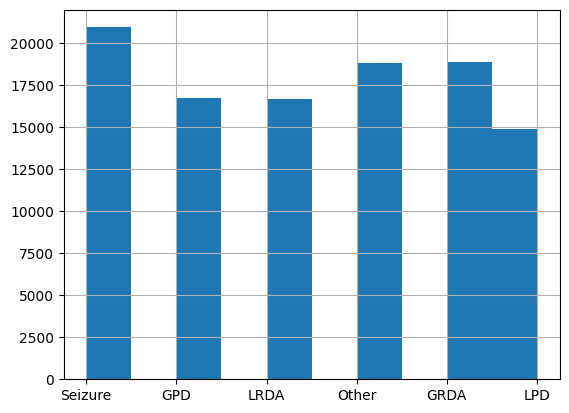

In [9]:
df['class_name'].hist()

In [10]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
"""##DataLoader"""
image_size = [400, 300]
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [12]:
from sklearn.model_selection import StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

In [13]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


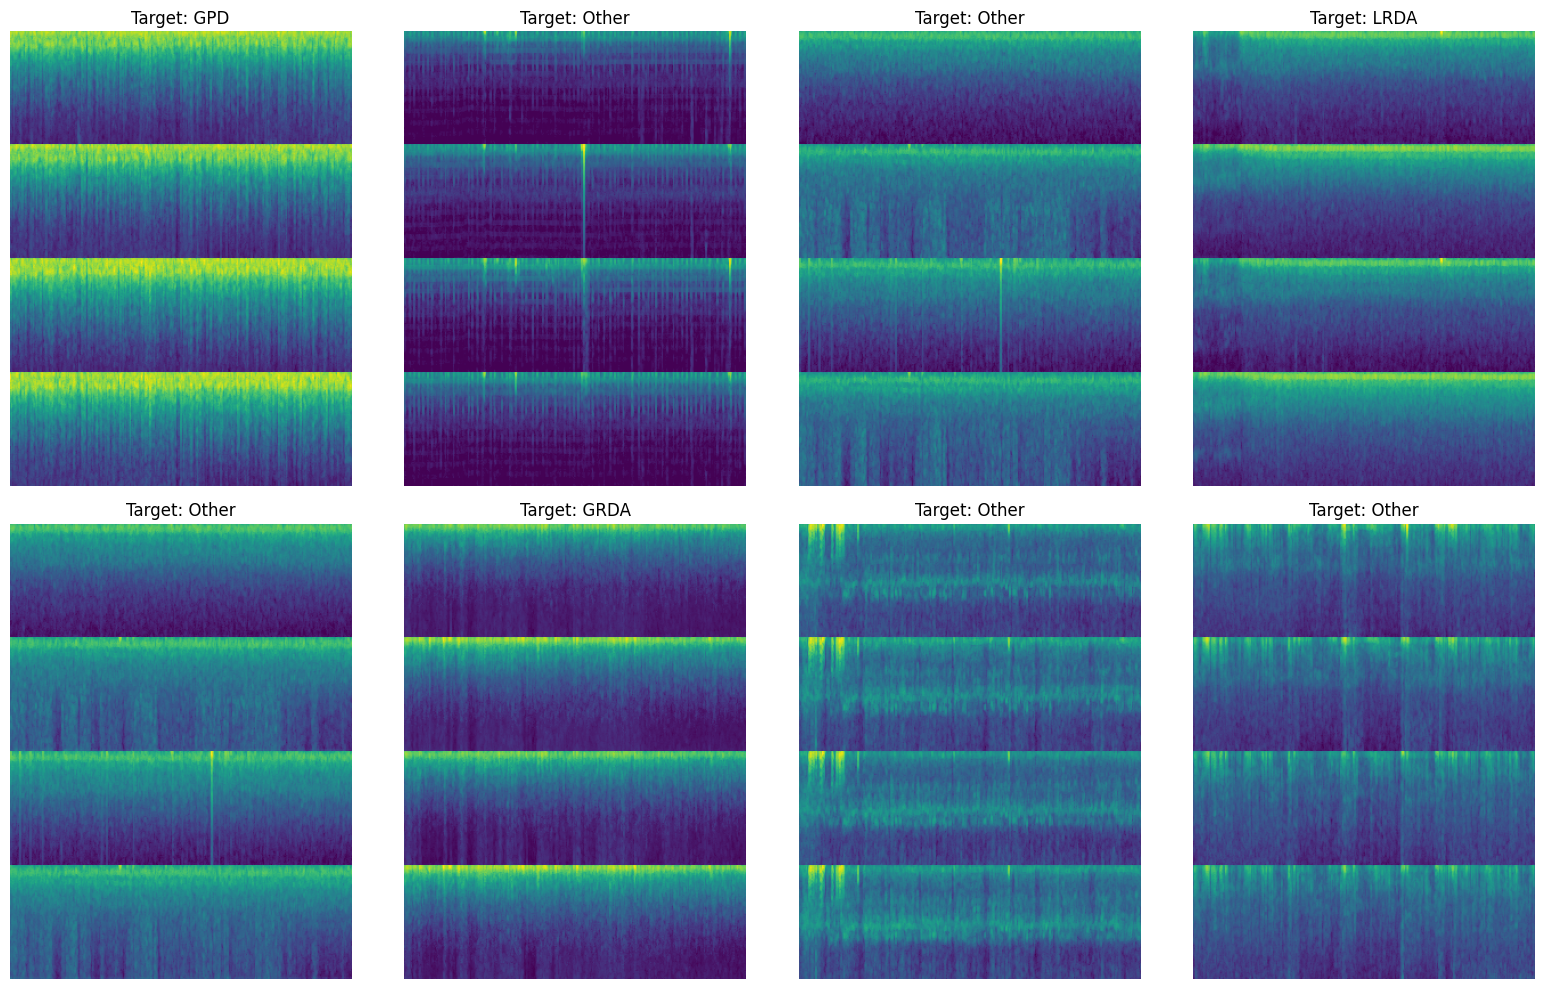

In [14]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [15]:
LOSS = keras.losses.KLDivergence()


**baseline model**

The baseline model is provided by competition. the result can be found here: https://www.kaggle.com/code/awsaf49/hms-hbac-kerascv-starter-notebook

Loss of baseline model after 13 epoch is Private Score : 0.759263

# Model 1

In [16]:
!pip install --upgrade keras

In [17]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

In [18]:
import os
import gc
import sys
import math
import time
import random
import datetime as dt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from typing import Dict, List, Union
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
sys.path.append("/kaggle/input/kaggle-kl-div")
from kaggle_kl_div import score
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
!cat /etc/os-release | grep -oP "PRETTY_NAME=\"\K([^\"]*)"
print(f"BUILD_DATE={os.environ['BUILD_DATE']}, CONTAINER_NAME={os.environ['CONTAINER_NAME']}")
try:
    print(
        f"PyTorch Version:{torch.__version__}, CUDA is available:{torch.cuda.is_available()}, Version CUDA:{torch.version.cuda}"
    )
    print(
        f"Device Capability:{torch.cuda.get_device_capability()}, {torch.cuda.get_arch_list()}"
    )
    print(
        f"CuDNN Enabled:{torch.backends.cudnn.enabled}, Version:{torch.backends.cudnn.version()}"
    )
except Exception:
    pass

Ubuntu 22.04.3 LTS
BUILD_DATE=20240109-221321, CONTAINER_NAME=tf2-gpu/2-13+gpu
PyTorch Version:2.0.0, CUDA is available:True, Version CUDA:11.8
Device Capability:(6, 0), ['sm_37', 'sm_60', 'sm_70', 'sm_75', 'compute_70', 'compute_75']
CuDNN Enabled:True, Version:8900


## Config

In [19]:
"""## Config"""
class CFG:
    model_name = "resnet1d_gru"
    seed = 2024
    batch_size = 32
    num_workers = 0
    fixed_kernel_size = 5
    kernels = [3, 5, 7, 9, 11]
    linear_layer_features = 304  # 1/5  Signal = 2_000
    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate  # Число семплов
    out_samples = nsamples // 5
    bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    freq_channels = []  # [(8.0, 12.0)]; [(0.5, 4.5)]
    filter_order = 2
    random_close_zone = 0.0  # 0.2
    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
    ]

    eeg_features = [
        "Fp1",
        "T3",
        "C3",
        "O1",
        "Fp2",
        "C4",
        "T4",
        "O2",
    ]  # 'Fz', 'Cz', 'Pz']
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'
    n_map_features = len(map_features)
    in_channels = (
        n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    )
    target_size = len(target_cols)
    PATH = "/kaggle/input/hms-harmful-brain-activity-classification/"
    test_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    test_csv = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"


In [20]:
koef_1 = 1.0
model_weights = [
    {
        'bandpass_filter':{'low':0.5, 'high':20, 'order':2}, 
        'file_data': 
        [
            {'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth"},
        ]
    },
]

## Utils

In [21]:
"""## Utils"""
def init_logger(log_file="./test.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x  # quantized


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y


## Parquet to EEG Signals Numpy Processing

In [22]:
"""## Parquet to EEG Signals Numpy Processing"""
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length
) -> np.ndarray:
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)
    offset = (rows - CFG.nsamples) // 2
    eeg = eeg.iloc[offset : offset + CFG.nsamples]
    if display:
        plt.figure(figsize=(10, 5))
        offset = 0
    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32")

        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()
        if nan_percentage < 1:  
            x = np.nan_to_num(x, nan=mean)
        else:  
            x[:] = 0
        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()
    return data



In [23]:

class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter

    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return output

    def __data_generation(self, index):
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        row = self.df.iloc[index]  
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode != "train":
                offset = (CFG.nsamples - CFG.out_samples) // 2
            else:
                # offset = random.randint(0, CFG.nsamples - CFG.out_samples)
                offset = (
                    (CFG.nsamples - CFG.out_samples) * random.randint(0, 1000)
                ) // 1000
            data = data[offset : offset + CFG.out_samples, :]

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if (
                self.mode == "train"
                and CFG.random_close_zone > 0
                and random.uniform(0.0, 1.0) <= CFG.random_close_zone
            ):
                continue

            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)

            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat,
                        lowcut,
                        highcut,
                        CFG.sampling_rate,
                        order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]

            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
        X = np.clip(X, -1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0
        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4
        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob


## Model

In [24]:
"""## Model"""
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        groups=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.maxpool(out)
        identity = self.downsampling(x)
        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
        groups=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                groups=groups,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()
        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            groups=groups,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
        )

        self.fc = nn.Linear(in_features=linear_layer_features, out_features=num_classes)

    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        groups=1,
        blocks=9,
        padding=0,
        dropout=0.0,
    ):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    groups=groups,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  
        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)
        return result

## Inference Function

In [25]:
def inference_function(test_loader, model, device):
    model.eval()  # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for step, batch in enumerate(tqdm_test_loader):
            X = batch.pop("eeg").to(device)  # send inputs to `device`
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X)  # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to("cpu").numpy())  # save predictions
    prediction_dict["predictions"] = np.concatenate(
        preds
    )
    return prediction_dict

## Load data

In [26]:
test_df = pd.read_csv(CFG.test_csv)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [27]:
test_eeg_parquet_paths = glob(CFG.test_eeg + "*.parquet")
test_eeg_df = pd.read_parquet(test_eeg_parquet_paths[0])
test_eeg_features = test_eeg_df.columns
print(f"There are {len(test_eeg_features)} raw eeg features")
print(list(test_eeg_features))
del test_eeg_df
_ = gc.collect()

# %%time
all_eegs = {}
eeg_ids = test_df.eeg_id.unique()
for i, eeg_id in tqdm(enumerate(eeg_ids)):
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = CFG.test_eeg + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)
    all_eegs[eeg_id] = data

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


0it [00:00, ?it/s]

## Inference 

In [28]:
koef_sum = 0
koef_count = 0
predictions = []
files = []
    
for model_block in model_weights:
    test_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="test",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

    if len(predictions) == 0:
        output = test_dataset[0]
        X = output["eeg"]
        print(f"X shape: {X.shape}")
                
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )

    for file_line in model_block['file_data']:
        koef = file_line['koef']
        for weight_model_file in glob(file_line['file_mask']):
            files.append(weight_model_file)
            checkpoint = torch.load(weight_model_file, map_location=device)
            model.load_state_dict(checkpoint["model"])
            model.to(device)
            prediction_dict = inference_function(test_loader, model, device)
            predict = prediction_dict["predictions"]
            predict *= koef
            koef_sum += koef
            koef_count += 1
            predictions.append(predict)
            torch.cuda.empty_cache()
            gc.collect()

predictions = np.array(predictions)
koef_sum /= koef_count
predictions /= koef_sum
predictions = np.mean(predictions, axis=0)

X shape: torch.Size([2000, 8])


Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

In [29]:
print(predictions)

[[0.02019469 0.0284991  0.00893613 0.07865793 0.10083617 0.762876  ]]


In [30]:
predss_1 = predictions
predss_1

array([[0.02019469, 0.0284991 , 0.00893613, 0.07865793, 0.10083617,
        0.762876  ]], dtype=float32)

In [31]:
model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )
print(model)

EEGNet(
  (parallel_conv): ModuleList(
    (0): Conv1d(8, 24, kernel_size=(3,), stride=(1,), bias=False)
    (1): Conv1d(8, 24, kernel_size=(5,), stride=(1,), bias=False)
    (2): Conv1d(8, 24, kernel_size=(7,), stride=(1,), bias=False)
    (3): Conv1d(8, 24, kernel_size=(9,), stride=(1,), bias=False)
    (4): Conv1d(8, 24, kernel_size=(11,), stride=(1,), bias=False)
  )
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): SiLU()
  (relu_2): SiLU()
  (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
  (block): Sequential(
    (0): ResNet_1D_Block(
      (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_1): Hardswish()
      (relu_2): Hardswish()
      (dropout): Dropout(p=0.0, inplace=False)
      (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_sta

# >> Model 2 <<

## Spectral Generator, Model and utility functions

In [32]:
import tensorflow as tf
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import albumentations as albu
from scipy.signal import butter, lfilter
import librosa
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization

LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = '/kaggle/input/features-head-starter-models'
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
if len(gpus)>1:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')


Using 1 GPU


## Load Test Data

In [33]:
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}
FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
USE_PROCESSED = True # Use processed downsampled Raw EEG 
    
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None , augment=False, 
                 mode='train', data_type='KER'): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        if self.data_type == 'KE':
            X,y = self.generate_all_specs(index)
        elif self.data_type == 'E' or self.data_type == 'K':
            X,y = self.generate_specs(index)
        elif self.data_type == 'R':
            X,y = self.generate_raw(index)
        elif self.data_type in ['ER','KR']:
            X1,y = self.generate_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif self.data_type in ['KER']:
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        if self.data_type in ['E','ER']:
            img = self.eeg_specs[row.eeg_id]
        elif self.data_type in ['K','KR']:
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
            return X,y
        
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

In [34]:
def spectrogram_from_eeg(parquet_path):    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')

    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
          
    return img

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data
# Load testing features
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
# Rename
test = test.rename({'spectrogram_id':'spec_id'},axis=1)
print('Test shape',test.shape)
test.head()
# Read all spectrograms
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
files = os.listdir(PATH)
print(f'There are {len(files)} test spectrogram parquets')
spectrograms = {}
for i,f in enumerate(files):
    tmp = pd.read_parquet(f'{PATH}/{f}')
    name = int(f.split('.')[0])
    spectrograms[name] = tmp.iloc[:,1:].values
# Read all EEG Spectrograms
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
DISPLAY = 0
EEG_IDS = test.eeg_id.unique()
all_eegs = {}
print('Converting Test EEG to Spectrograms...')
for i,eeg_id in enumerate(EEG_IDS):
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}/{eeg_id}.parquet')
    all_eegs[eeg_id] = img
# Read all RAW EEG Signals
all_raw_eegs = {}
EEG_IDS = test.eeg_id.unique()
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
print('Processing Test EEG parquets...')
for i,eeg_id in enumerate(EEG_IDS):
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH}/{eeg_id}.parquet')
    all_raw_eegs[eeg_id] = data

Test shape (1, 3)
There are 1 test spectrogram parquets
Converting Test EEG to Spectrograms...
Processing Test EEG parquets...


In [35]:
DATA_TYPE = 'KER' # K|E|R|KE|KR|ER|KER
# Submission ON TEST without ensemble
def preds_without_ensemble(VER=50):
    preds = []
    
    test_dataset = dataset(test,mode='test',specs=spectrograms2, eeg_specs=all_eegs2, raw_eegs=all_raw_eegs2)
    model = build_model()

    for i in range(5):
        print(f'Fold {i+1}')
        model.load_weights(f'{LOAD_MODELS_FROM}/model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        pred = model.predict(test_dataset, verbose=1)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [36]:
# Setup for ensemble
ENSEMBLE = True
#LBs = [0.41,0.39,0.41,0.37,0.39,0.38,0.36] # K|E|R|KE|KR|ER|KER for weighted ensemble we use LBs of each model
LBs = [0.81,0.79,0.81,0.77,0.79,0.78,0.76]
VER_K = 43 # Kaggle's spectrogram model version
VER_E = 42 # EEG's spectrogram model version
VER_R = 60 #37 # EEG's Raw wavenet model version, trained on single GPU
VER_KE = 58 #47 # Kaggle's and EEG's spectrogram model version
VER_KR = 48 # Kaggle's spectrogram and Raw model version
VER_ER = 49 # EEG's spectrogram and Raw model version
VER_KER = 50 # EEG's, Kaggle's spectrograms and Raw model version

In [37]:
def create_dataset(data, mode='train', batch_size=8, data_type=DATA_TYPE, 
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):
    
    BATCH_SIZE_PER_REPLICA = batch_size
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    if data_type in ['K','E','KE']: 
        inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)
    elif data_type in ['KR','ER','KER']:
        inp = (tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),tf.TensorSpec(shape=(2000,8), dtype=tf.float32))
    elif data_type in ['R']:
        inp = tf.TensorSpec(shape=(2000,8), dtype=tf.float32)
        
    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        BATCH_SIZE)
    return dataset

In [38]:
def build_spec_model(hybrid=False):  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def build_wave_model(hybrid=False):
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    if not hybrid:
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def build_hybrid_model():
    model_spec = build_spec_model(True)
    model_wave = build_wave_model(True)
    inputs = [model_spec.input, model_wave.input]
    x = [model_spec.output, model_wave.output]
    x = tf.keras.layers.Concatenate()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [39]:
# Submission ON TEST with ensemble
def preds_with_ensemble():
    preds = []
    params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
    test_dataset_K = create_dataset(test, data_type='K', mode='test', **params)
    test_dataset_E = create_dataset(test, data_type='E', mode='test', **params)
    test_dataset_R = create_dataset(test, data_type='R', mode='test', **params)
    test_dataset_KE = create_dataset(test, data_type='KE', mode='test', **params)
    test_dataset_KR = create_dataset(test, data_type='KR', mode='test', **params)
    test_dataset_ER = create_dataset(test, data_type='ER', mode='test', **params)
    test_dataset_KER = create_dataset(test, data_type='KER', mode='test', **params)

    # LB SCORE WEIGHTS FOR EACH MODEL
    lbs = 1 - np.array(LBs)
    weights = lbs/lbs.sum()
    model_spec = build_spec_model()
    model_wave = build_wave_model()
    model_hybrid = build_hybrid_model()
    
    for i in range(5):
        print(f'Fold {i+1}')
        # Kaggle's spectrogram model 
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_K_{VER_K}_{i}.weights.h5')
        pred_K = model_spec.predict(test_dataset_K, verbose=1)
        # EEG's spectrogram model
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_E_{VER_E}_{i}.weights.h5')
        pred_E = model_spec.predict(test_dataset_E, verbose=1)
        # EEG's Raw wavenet model
        model_wave.load_weights(f'{LOAD_MODELS_FROM}/model_R_{VER_R}_{i}.weights.h5')
        pred_R = model_wave.predict(test_dataset_R, verbose=1)
        # Kaggle's and EEG's spectrogram model
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_KE_{VER_KE}_{i}.weights.h5')
        pred_KE = model_spec.predict(test_dataset_KE, verbose=1)
        # Kaggle's spectrogram and Raw model
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_KR_{VER_KR}_{i}.weights.h5')
        pred_KR = model_hybrid.predict(test_dataset_KR, verbose=1)
        # EEG's spectrogram and Raw model
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_ER_{VER_ER}_{i}.weights.h5')
        pred_ER = model_hybrid.predict(test_dataset_ER, verbose=1)
        # EEG's, Kaggle's spectrograms and Raw model
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_KER_{VER_KER}_{i}.weights.h5')
        pred_KER = model_hybrid.predict(test_dataset_KER, verbose=1)
        # Combine the predictions from all the model with different weights 
        pred = np.array([pred_K,pred_E,pred_R,pred_KE,pred_KR,pred_ER,pred_KER])
        pred = np.average(pred,axis=0,weights=weights)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    return pred

# Prediction with 
pred = preds_with_ensemble()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 0s 184ms/step
Fold 2
1/1 [==============================] - 0s 174ms/step
Fold 3
1/1 [==============================] - 0s 177ms/step
Fold 4
1/1 [==============================] - 0s 163ms/step
Fold 5
1/1 [==============================] - 0s 177ms/step
Test preds shape (1, 6)


In [40]:
model_spec = build_hybrid_model()
model_spec.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 2000, 8)]            0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 2000, 1)              0         ['input_8[0][0]']             
 6 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_1  (None, 2000, 1)              0         ['input_8[0][0]']             
 7 (SlicingOpLambda)                                                                              
                                                                                           

## Predict

In [41]:
predss_2 = pred
predss_2

array([[0.05228921, 0.05957176, 0.00158099, 0.38807299, 0.02695576,
        0.47152926]])

# >>Model 3<<

In [42]:
from IPython.display import display
import timm  
import torch.optim as optim
import torchvision.transforms as transforms
from scipy import signal

warnings.filterwarnings('ignore', category=Warning)
gc.collect()

165325

In [43]:
class Config:
    seed = 3131
    image_transform = transforms.Resize((512, 512))
    num_folds = 5
    dataset_wide_mean = -0.2972692229201065 #From Train notebook
    dataset_wide_std = 2.5997336315611026 #From Train notebook
    ownspec_mean = 7.29084372799223e-05 # From Train spectrograms notebook
    ownspec_std = 4.510082606216031 # From Train spectrograms notebook
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

In [44]:
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")

submission = submission.merge(test_df, on='eeg_id', how='left')
submission['path_spec'] = submission['spectrogram_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{x}.parquet")
submission['path_eeg'] = submission['eeg_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{x}.parquet")
display(submission)

gc.collect()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,patient_id,path_spec,path_eeg
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,853520,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...


0

In [45]:
models = []

# Load in original EfficientnetB0 model
for i in range(Config.num_folds):
    model_effnet_b0 = timm.create_model('efficientnet_b0', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b0.load_state_dict(torch.load(f'/kaggle/input/hms-train-efficientnetb0/efficientnet_b0_fold{i}.pth', map_location=torch.device('cpu')))
    models.append(model_effnet_b0)
    
models_datawide = []
# Load in hyperparameter optimized EfficientnetB1
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/train/efficientnet_b1_fold{i}.pth', map_location=torch.device('cpu')))
    models_datawide.append(model_effnet_b1)
    
models_ownspec = []
# Load in EfficientnetB1 with new spectrograms
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/efficientnet-b1-ownspectrograms/efficientnet_b1_fold{i}_datawide_CosineAnnealingLR_0.001_False.pth', map_location=torch.device('cpu')))
    models_ownspec.append(model_effnet_b1)
    
gc.collect()

63

In [46]:
test_predictions = []

def create_spectrogram(data):
    """This function will create a spectrogram based on EEG-data"""
    nperseg = 150  # Length of each segment
    noverlap = 128  # Overlap between segments
    NFFT = max(256, 2 ** int(np.ceil(np.log2(nperseg))))

    # LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4
    freqs, t,spectrum_LL1 = signal.spectrogram(data['Fp1']-data['F7'],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL2 = signal.spectrogram(data['F7']-data['T3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL3 = signal.spectrogram(data['T3']-data['T5'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL4 = signal.spectrogram(data['T5']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LL = (spectrum_LL1+ spectrum_LL2 +spectrum_LL3 + spectrum_LL4)/4

    # LP Spec = ( spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1) )/4
    freqs, t,spectrum_LP1 = signal.spectrogram(data['Fp1']-data['F3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP2 = signal.spectrogram(data['F3']-data['C3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP3 = signal.spectrogram(data['C3']-data['P3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP4 = signal.spectrogram(data['P3']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LP = (spectrum_LP1+ spectrum_LP2 +spectrum_LP3 + spectrum_LP4)/4

    # RP Spec = ( spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2) )/4
    freqs, t,spectrum_RP1 = signal.spectrogram(data['Fp2']-data['F4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP2 = signal.spectrogram(data['F4']-data['C4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP3 = signal.spectrogram(data['C4']-data['P4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP4 = signal.spectrogram(data['P4']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    RP = (spectrum_RP1+ spectrum_RP2 +spectrum_RP3 + spectrum_RP4)/4


    # RL Spec = ( spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2) )/4
    freqs, t,spectrum_RL1 = signal.spectrogram(data['Fp2']-data['F8'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL2 = signal.spectrogram(data['F8']-data['T4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL3 = signal.spectrogram(data['T4']-data['T6'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL4 = signal.spectrogram(data['T6']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    RL = (spectrum_RL1+ spectrum_RL2 +spectrum_RL3 + spectrum_RL4)/4
    spectogram = np.concatenate((LL, LP,RP,RL), axis=0)
    return spectogram

def preprocess_ownspec(path_to_parquet):
    """The data will be processed from EEG to spectrogramdata"""
    data = pd.read_parquet(path_to_parquet)
    data = create_spectrogram(data)
    mask = np.isnan(data)
    data[mask] = -1
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data 

def preprocess(path_to_parquet):
    data = pd.read_parquet(path_to_parquet)
    data = data.fillna(-1).values[:, 1:].T
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data


def normalize_datawide(data_point):
    """The spectrogram data will be normalized data wide."""
    eps = 1e-6

    data_point = (data_point - Config.dataset_wide_mean) / (Config.dataset_wide_std + eps)

    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)

    return data_point


def normalize_datawide_ownspec(data):
    """The new spectrogram data will be normalized data wide."""
    eps = 1e-6
    
    data = (data - Config.ownspec_mean) / (Config.ownspec_std + eps)
    data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
    data = Config.image_transform(data_tensor)
    
    return data


def normalize_instance_wise(data_point):
    """The spectrogram data will be normalized instance wise."""
    eps = 1e-6
    
    data_mean = data_point.mean(axis=(0, 1))
    data_std = data_point.std(axis=(0, 1))
    data_point = (data_point - data_mean) / (data_std + eps)
    
    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)
    
    return data_point

# Loop over samples
for index in submission.index:
    test_predictions_per_model = []
    
    preprocessed_data = preprocess(submission.iloc[index]['path_spec'])
    preprocessed_data_ownspec = preprocess_ownspec(submission.iloc[index]['path_eeg'])
    
    # Predict based on original EfficientnetB0 models. 
    for i in range(len(models)):
        models[i].eval()
        
        current_parquet_data = normalize_instance_wise(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Predict based on hyperparameter optimized EffcientnetB1.
    for i in range(len(models_datawide)):
        models_datawide[i].eval()
        
        current_parquet_data = normalize_datawide(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_datawide[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Predict based on EfficientnetB1 model with new spectrograms.
    for i in range(len(models_ownspec)):
        models_ownspec[i].eval()
        
        current_parquet_data = normalize_datawide_ownspec(preprocessed_data_ownspec).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_ownspec[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # The mean of all models is taken.
    ensemble_prediction = np.mean(test_predictions_per_model,axis=0)
    
    test_predictions.append(ensemble_prediction)

test_predictions = np.array(test_predictions)

gc.collect()

0

In [47]:
predss_3 = test_predictions
predss_3

array([[0.03419812, 0.07484972, 0.001024  , 0.38697532, 0.01671714,
        0.48623565]], dtype=float32)

# Submission Model 1 + Model 2 + Model 3

Weight for model 1, model 2, model 3 is 0.45; 0.15; 0.40 respectively

In [48]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=(predss_1[:,i] * 0.45 + predss_2[:, i] * 0.15 + predss_3[:, i] * 0.40)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.03061,0.0517,0.004668,0.248397,0.056106,0.608518


In [49]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
submission.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float64

## Submission results

Our submission is successul sunmited, the loss as follows picture. \
Note that version 4,5,7 is each of 3 model only and the version 2 is the combine of 3 model by ensemble learning method.

The leaderboard can be found here:https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/leaderboard

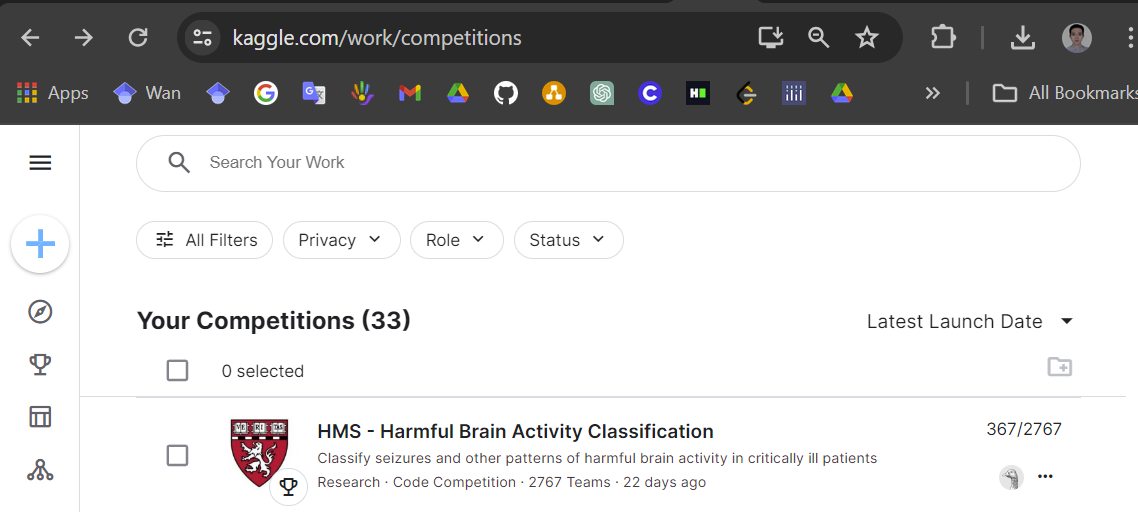

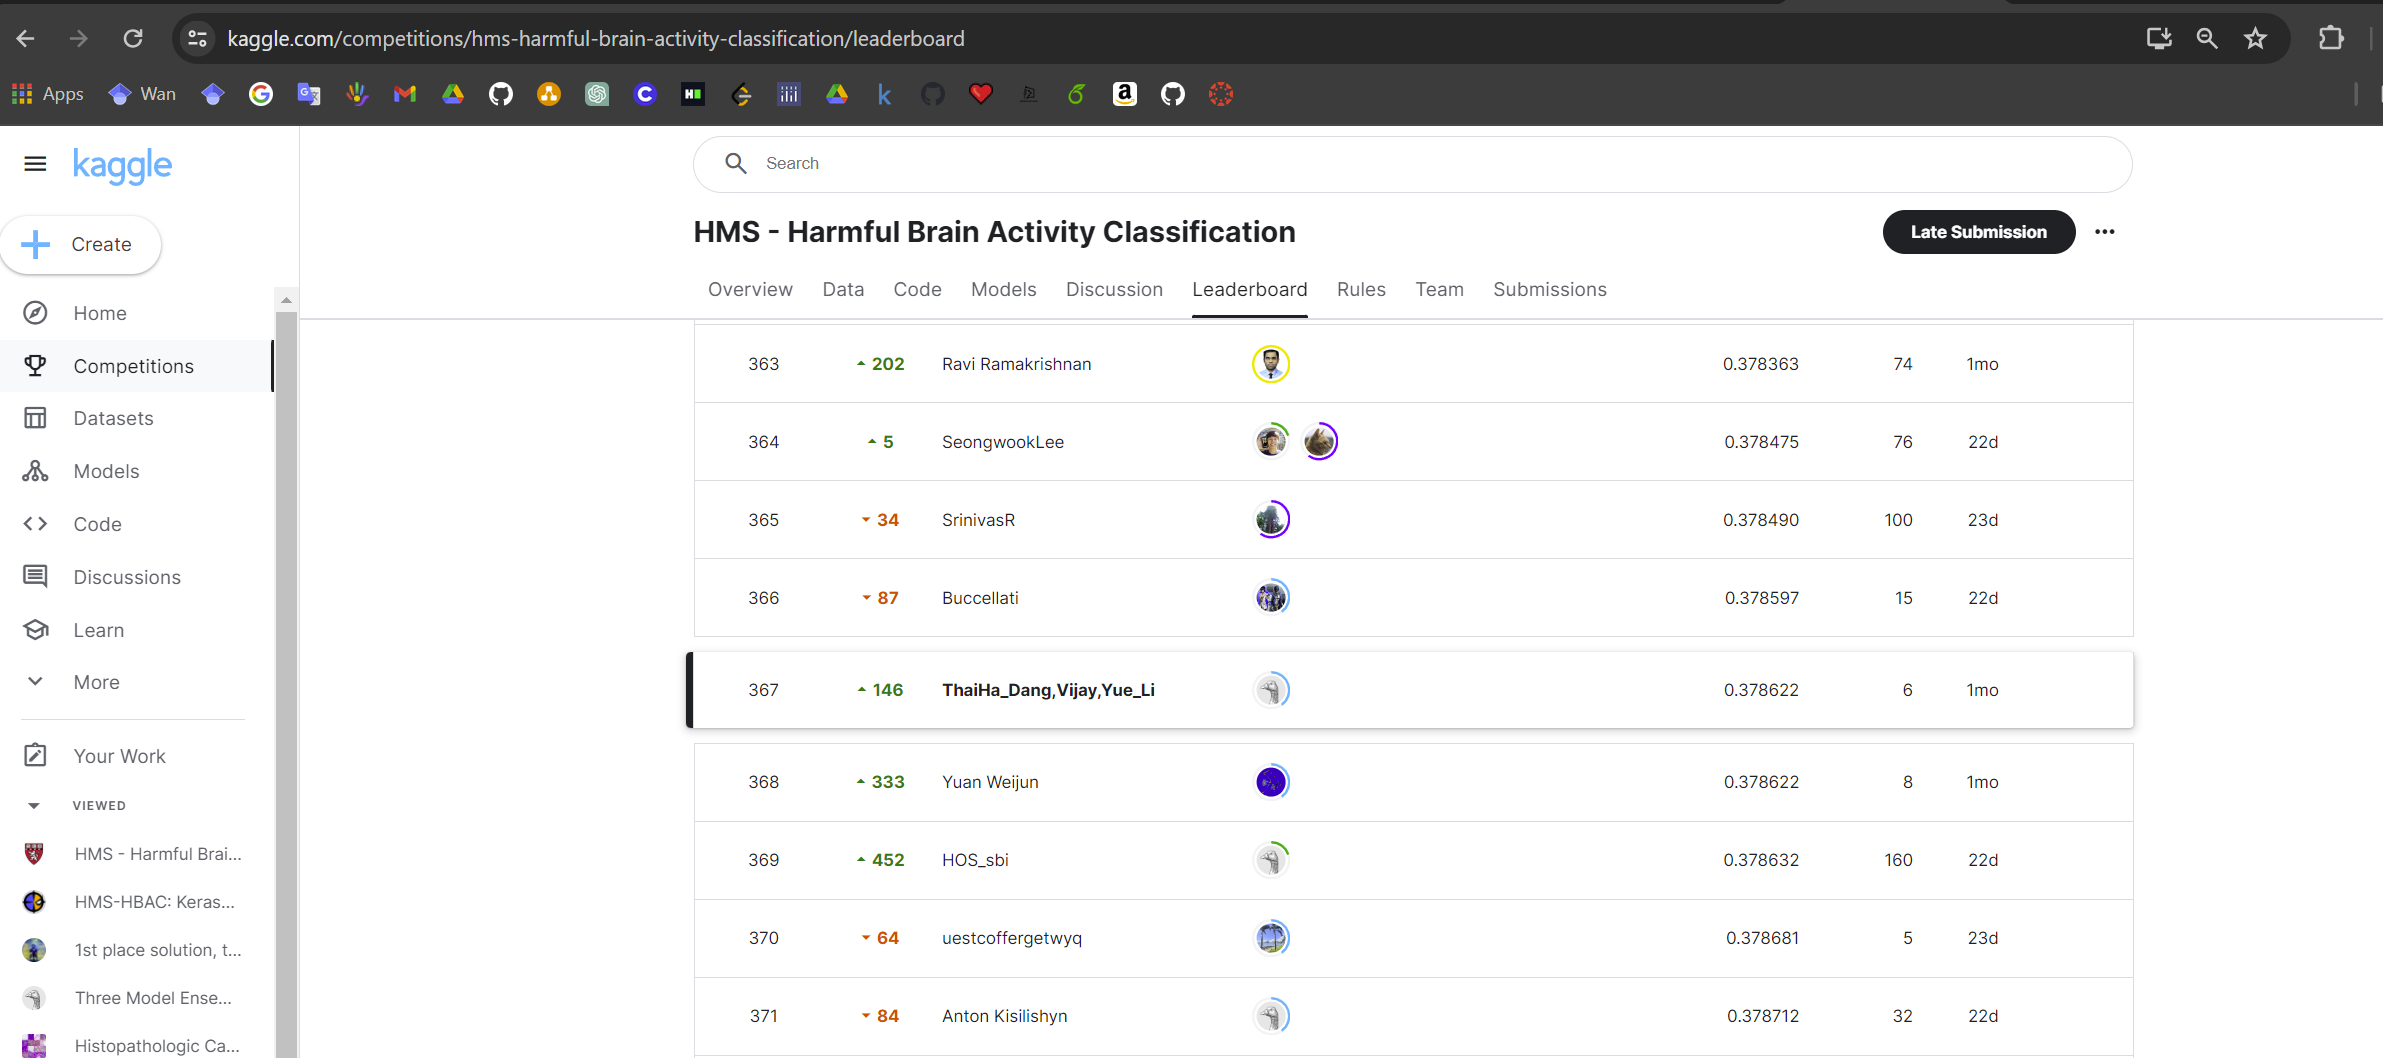